In [35]:
#Importação de bibliotecas
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import warnings
import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.tools as tls
import plotly.figure_factory as ff
import plotly.express as px
from mlxtend.evaluate import confusion_matrix
from mlxtend.plotting import plot_confusion_matrix
import os
import cv2
import imgaug.augmenters as iaa
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from keras.layers import BatchNormalization
from imblearn.over_sampling import RandomOverSampler
from collections import Counter

In [36]:
#Semente randômica para garantir reprodução
tf.random.set_seed(0)

In [37]:
#Diretório onde então localizadas as pastas com as imagens
main_dir = os.listdir(r'C:\Users\mathe\Google Drive\Pneumonia_Xray\Dataset\chest_xray\chest_xray')

#Diretório para as pastas que contém imagens de treino, teste e validação
train_folder = r'C:\Users\mathe\Google Drive\Pneumonia_Xray\Dataset\chest_xray\chest_xray\train/'
test_folder = r'C:\Users\mathe\Google Drive\Pneumonia_Xray\Dataset\chest_xray\chest_xray\test/'
val_folder = r'C:\Users\mathe\Google Drive\Pneumonia_Xray\Dataset\chest_xray\chest_xray\val/'

train_normal = train_folder + 'NORMAL/'
train_pneumonia = train_folder + 'PNEUMONIA/'

test_normal = test_folder + 'NORMAL/'
test_pneumonia = test_folder + 'PNEUMONIA/'

val_normal = val_folder + 'NORMAL/'
val_pneumonia = val_folder + 'PNEUMONIA/'

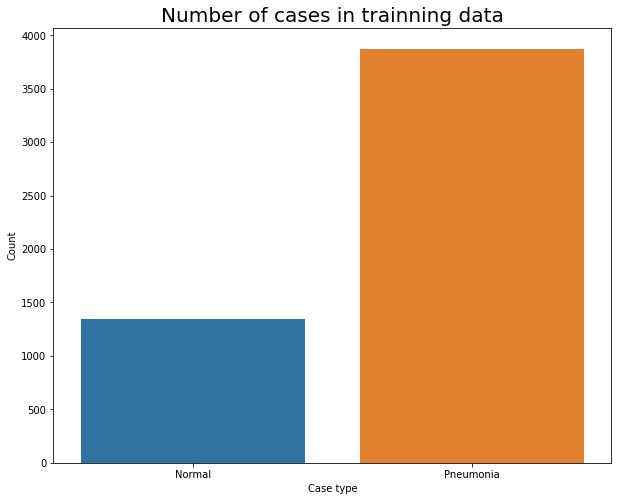

In [38]:
#Verificação se a base de dados para treina está balanceada

values = [len(os.listdir(train_normal)), len(os.listdir(train_pneumonia))]
labels = ['Normal', 'Pneumonia']

plt.figure(figsize = (10, 8))
sns.barplot(x = labels, y = values)
plt.title("Number of cases in trainning data", fontsize = 20)
plt.xlabel('Case type')
plt.ylabel('Count')
plt.show()


A base de dados está desbalanceanda, contendo mais casos de pneumonia. Isso será corrigido gerando mais dados de casos 'normal'

In [39]:
#Normal label picture
norm_pic = os.listdir(train_normal)[1]
norm_pic_address = train_normal+norm_pic

#Pneumonia label picture
pneum_pic = os.listdir(train_pneumonia)[1]
pneum_address = train_pneumonia+pneum_pic

#Função para modificar o tamanho das imagens
def resize_image(img_path):
    """Função utilizada para modificar a dimensão  da imagem"""
    img_arr = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
    resized_arr = cv2.resize(img_arr, (200, 200))
    return resized_arr

Normal picture title:  IM-0117-0001.jpeg
Pneumonia picture title:  person1000_virus_1681.jpeg


Text(0.5, 1.0, 'Pneumonia')

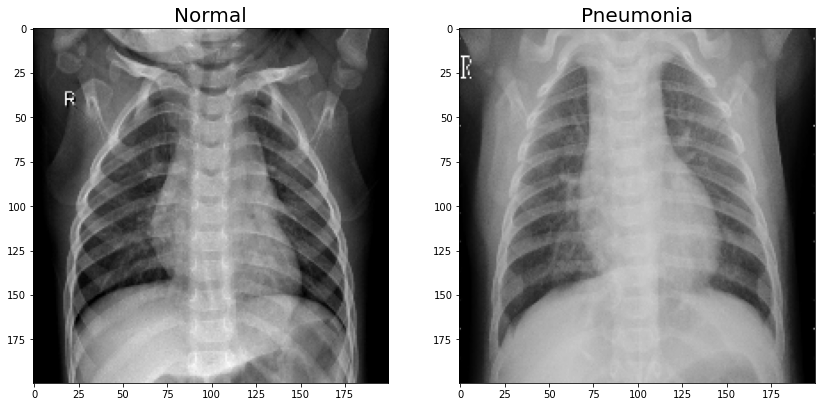

In [40]:
#Mostra imagens 

normal_resized = resize_image(norm_pic_address)
print('Normal picture title: ', norm_pic)

fig = plt.figure(figsize = (14, 12))
ax = fig.add_subplot(1, 2, 1)
plt.imshow(normal_resized, cmap = 'gray')
ax.set_title('Normal', fontdict = {'fontsize': 20})

pneum_resized = resize_image(pneum_address)
print('Pneumonia picture title: ', pneum_pic)

ax = fig.add_subplot(1, 2, 2)
plt.imshow(pneum_resized, cmap = 'gray')
ax.set_title('Pneumonia', fontdict = {'fontsize': 20})

In [41]:
#Lista  vazias para armazenar imagens

train_list = []
test_list = []
val_list = []

for x in os.listdir(train_normal):
    train_list.append([train_normal + x, 0])

for x in os.listdir(train_pneumonia):
    train_list.append([train_pneumonia + x, 1])

for x in os.listdir(test_normal):
    test_list.append([test_normal + x, 0])

for x in os.listdir(test_pneumonia):
    test_list.append([test_pneumonia + x, 1])

for x in os.listdir(val_normal):
    val_list.append([val_normal + x, 0])

for x in os.listdir(val_pneumonia):
    val_list.append([val_pneumonia + x, 1])


In [42]:
#Criação de data frames

train_df = pd.DataFrame(train_list, columns = ["Image", "Label"])
test_df = pd.DataFrame(test_list, columns = ["Image", "Label"])
val_df = pd.DataFrame(val_list, columns = ["Image", "Label"])

In [43]:
def process_data(image_path):
    """Função utilizada para alterar o tamanho da imagem para 200x200,
       converter para grayscale, e normalizar os valores"""
    try:
        img = cv2.imread(image_path)
        img = cv2.resize(img, (200, 200))
        img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        img = img.astype(np.float32) / 255.0
        img = np.reshape(img, (200, 200, 1))
        
        return img
    except Exception as e:
        print(str(e))
        print(image_path)

def compose_dataset(df):
    """Função para separar em listas separadas, os dados das imagens e suas respectivas labels"""
    data = []
    labels = []

    for img_path, label in df.values:
        data.append(process_data(img_path))
        labels.append(label)
    
    return np.array(data), np.array(labels)

In [44]:
#Convertendo imagens para array
X_train, y_train = compose_dataset(train_df)
X_test, y_test = compose_dataset(test_df)
X_val, y_val = compose_dataset(val_df)

In [45]:
#Data augmentation

aug = iaa.OneOf([
    iaa.Affine(rotate = (-10, 10)),
    iaa.Affine(scale = (0.8, 1.3)),
])

for i in range(len(X_train)):
    X_train[i] = aug.augment_image(image = X_train[i])

In [46]:
#Alteração do shape, para fazer a reamostragem de imagens 

X_reshaped = X_train.reshape(X_train.shape[0], 200 * 200)

In [48]:
#Reamostragem de dados para balancear as classes
ros = RandomOverSampler(random_state = 0)
X_resampled, y_resampled = ros.fit_resample(X_reshaped, y_train)

In [49]:
#Verificação se as classes foram balanceadas
print(sorted(Counter(y_resampled).items()))

[(0, 3875), (1, 3875)]


In [50]:
X_train = X_resampled.reshape(X_resampled.shape[0], 200, 200, 1)
y_train = y_resampled

In [51]:
y_train = y_train.reshape(-1, 1)
y_test = y_test.reshape(-1, 1)
y_val = y_val.reshape(-1, 1)

In [68]:
#Construção de rede CNN

model = Sequential()

model.add(Conv2D(filters = 8, kernel_size = (5,5), padding = 'same', activation = 'relu', input_shape = (200, 200, 1)))
model.add(MaxPooling2D(pool_size = (3,3)))
model.add(BatchNormalization())
model.add(Dropout(0.2))

model.add(Conv2D(filters = 16, kernel_size = (3,3), padding = 'same', activation = 'relu'))
model.add(MaxPooling2D(pool_size = (3,3)))
model.add(BatchNormalization())

model.add(Conv2D(filters = 32, kernel_size = (3,3), padding = 'same', activation = 'relu'))
model.add(MaxPooling2D(pool_size = (2,2)))
model.add(BatchNormalization())

model.add(Conv2D(filters = 64, kernel_size = (3,3), padding = 'same', activation = 'relu'))
model.add(MaxPooling2D(pool_size = (2,2)))

model.add(Flatten())

model.add(Dense(200, activation = 'relu'))
model.add(Dropout(0.2))

model.add(Dense(1, activation = 'sigmoid'))

model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_16 (Conv2D)           (None, 200, 200, 8)       208       
_________________________________________________________________
max_pooling2d_16 (MaxPooling (None, 66, 66, 8)         0         
_________________________________________________________________
batch_normalization_12 (Batc (None, 66, 66, 8)         32        
_________________________________________________________________
dropout_5 (Dropout)          (None, 66, 66, 8)         0         
_________________________________________________________________
conv2d_17 (Conv2D)           (None, 66, 66, 16)        1168      
_________________________________________________________________
max_pooling2d_17 (MaxPooling (None, 22, 22, 16)        0         
_________________________________________________________________
batch_normalization_13 (Batc (None, 22, 22, 16)       

In [70]:
#Definição de loss, otimizador e métrica de erro
model.compile(loss = 'binary_crossentropy', optimizer = 'adam', metrics = 'accuracy')

In [71]:
hist = model.fit(X_train, y_train, batch_size = 64, epochs = 15, validation_data = (X_val, y_val), verbose = 2, shuffle = True)

Epoch 1/15
122/122 - 6s - loss: 0.2505 - accuracy: 0.9045 - val_loss: 1.3434 - val_accuracy: 0.5000
Epoch 2/15
122/122 - 5s - loss: 0.1157 - accuracy: 0.9560 - val_loss: 2.8313 - val_accuracy: 0.5000
Epoch 3/15
122/122 - 5s - loss: 0.0738 - accuracy: 0.9734 - val_loss: 3.0676 - val_accuracy: 0.5000
Epoch 4/15
122/122 - 5s - loss: 0.0623 - accuracy: 0.9790 - val_loss: 1.7110 - val_accuracy: 0.6250
Epoch 5/15
122/122 - 5s - loss: 0.0451 - accuracy: 0.9830 - val_loss: 1.2742 - val_accuracy: 0.6250
Epoch 6/15
122/122 - 5s - loss: 0.0752 - accuracy: 0.9705 - val_loss: 0.7268 - val_accuracy: 0.8125
Epoch 7/15
122/122 - 5s - loss: 0.0355 - accuracy: 0.9870 - val_loss: 1.1197 - val_accuracy: 0.6875
Epoch 8/15
122/122 - 5s - loss: 0.0244 - accuracy: 0.9923 - val_loss: 1.2807 - val_accuracy: 0.7500
Epoch 9/15
122/122 - 5s - loss: 0.0218 - accuracy: 0.9933 - val_loss: 1.5898 - val_accuracy: 0.7500
Epoch 10/15
122/122 - 5s - loss: 0.0129 - accuracy: 0.9959 - val_loss: 1.5749 - val_accuracy: 0.6875

In [72]:
#Gráficos de accuracy 

x = hist.epoch
y_acc_train = hist.history['accuracy']
y_acc_val = hist.history['val_accuracy']

data = [go.Scatter(
                x = x,
                y = y_acc_train,
                line = dict(color = 'green', width = 2),
                #marker = dict(line = dict(width = 1.5, color = 'black'), color = 'rgb(30,144,255)'),
                #text = ['teste 1', 'teste 2'],     #Lista de texto para cada elemento do gráfico
                #hovertemplate = "<b>%{text}</b><br><br>" + '<b>City: </b>%{x}<br>' + '<b>Count: </b>%{y}',
                hovertemplate = '<b>Epoch: </b>%{x}<br>' + '<b>Accuracy: </b>%{y}',
                mode = 'lines+markers',
                opacity = 0.7,
                name = 'Train'
                ),
          go.Scatter(
                x = x,
                y = y_acc_val,
                line = dict(color = 'red', width = 2),
                #marker = dict(line = dict(width = 1.5, color = 'black'), color = 'rgb(30,144,255)'),
                #text = ['teste 1', 'teste 2'],     #Lista de texto para cada elemento do gráfico
                #hovertemplate = "<b>%{text}</b><br><br>" + '<b>City: </b>%{x}<br>' + '<b>Count: </b>%{y}',
                hovertemplate = '<b>Epoch: </b>%{x}<br>' + '<b>Accuracy: </b>%{y}',
                mode = 'lines+markers',
                opacity = 0.7,
                name = 'Validation'
                )
          ]

layout = go.Layout(
    title = 'Accuracy train and validation data',
    xaxis = dict(showgrid = True, gridcolor = "#eee", title = 'Epochs'),
    yaxis = dict(showgrid = True, gridcolor = "#eee", title = 'Accuracy'),
    plot_bgcolor = "white",
    paper_bgcolor = "white",
    height = 600, 
    width = 1000)
                    
fig = dict(data = data, layout = layout)
py.iplot(fig)

In [73]:
#Gráficos de loss

x = hist.epoch
y_loss_train = hist.history['loss']
y_loss_val = hist.history['val_loss']

data = [go.Scatter(
                x = x,
                y = y_loss_train,
                line = dict(color = 'green', width = 2),
                #marker = dict(line = dict(width = 1.5, color = 'black'), color = 'rgb(30,144,255)'),
                #text = ['teste 1', 'teste 2'],     #Lista de texto para cada elemento do gráfico
                #hovertemplate = "<b>%{text}</b><br><br>" + '<b>City: </b>%{x}<br>' + '<b>Count: </b>%{y}',
                hovertemplate = '<b>Epoch: </b>%{x}<br>' + '<b>Loss: </b>%{y}',
                mode = 'lines+markers',
                opacity = 0.7,
                name = 'Train'
                ),
          go.Scatter(
                x = x,
                y = y_loss_val,
                line = dict(color = 'red', width = 2),
                #marker = dict(line = dict(width = 1.5, color = 'black'), color = 'rgb(30,144,255)'),
                #text = ['teste 1', 'teste 2'],     #Lista de texto para cada elemento do gráfico
                #hovertemplate = "<b>%{text}</b><br><br>" + '<b>City: </b>%{x}<br>' + '<b>Count: </b>%{y}',
                hovertemplate = '<b>Epoch: </b>%{x}<br>' + '<b>Loss: </b>%{y}',
                mode = 'lines+markers',
                opacity = 0.7,
                name = 'Validation'
                )
          ]

layout = go.Layout(
    title = 'Loss train and validation data',
    xaxis = dict(showgrid = True, gridcolor = "#eee", title = 'Epochs'),
    yaxis = dict(showgrid = True, gridcolor = "#eee", title = 'Loss'),
    plot_bgcolor = "white",
    paper_bgcolor = "white",
    height = 600, 
    width = 1000)
                    
fig = dict(data = data, layout = layout)
py.iplot(fig)



In [74]:
y_pred = model.predict(X_test)
y_pred = np.round(y_pred, decimals = 0)

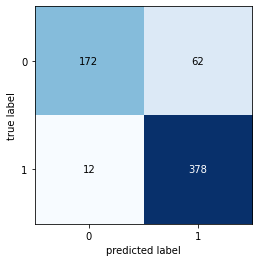

In [75]:
#Confusion matrix

cm = confusion_matrix(y_target=y_test, y_predicted=y_pred)
fig, ax = plot_confusion_matrix(conf_mat=cm)
plt.show()

Foram realizados testes com maiores números de épocas (geralmente maior que 15), o modelo apresentava problemas de overfitting, classificando muitas imagens como falso positivo.